# Database Builder

This notebook provides information and builds graphs and plots starting from the data in the database (database/database.sqlite). <br>

If database does not exist, an error will occur.
<hr>

#### Requirements

In [ ]:
#! pip install seaborn 
#! pip install palettable
#! pip install plotly
#! pip install matplotlib_venn
#! pip install lib
#! pip install matplotlib
#! pip install numpy

#### DB Connection

In [1]:
import os, sys
sys.path.append("..")
from lib.sqlite_utils import DBConnection 
 

if not os.path.exists(os.path.join('..','database','database.sqlite')):
    raise Exception('Database does not exists! You need to create it first (db_builder.ipynb)')

conn=DBConnection(os.path.join('..','database','database.sqlite'))

#### Utilities

In [2]:
import palettable
import matplotlib.colors as mcolors
import numpy as np

np.random.seed(42)
data = np.random.rand(10,10) * 100 
r=list(np.linspace(0.3, 1, 256)) 
for i in range(20):
    r.extend(np.linspace(0.3, 1, 256)) 
r.sort()

colors0 = palettable.colorbrewer.sequential.YlOrBr_8.mpl_colormap(np.linspace(0, 0.3, 256))
colors1 = palettable.colorbrewer.sequential.YlOrBr_8.mpl_colormap(r)
colors2 = palettable.colorbrewer.sequential.Reds_9.mpl_colormap(np.linspace(0.9, 0.9, 256)) 
colors = np.vstack(( colors0,colors1, colors2 ))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

def get_el_position(x_values,y_values, element):
    for x in x_values:
        for y in y_values:
            if element[0]>=x[0] and element[0]<x[1]:
                if element[1]>=y[0] and element[1]<y[1]:
                    return x_values.index(x), y_values.index(y)
    return (-1,-1)

#### Getting dataset sizes

In [3]:
sizes = dict()
query = 'SELECT * FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE {}'
sizes['IT'] = len(conn.query(query.format('o.country="Italy"')))
sizes['DE'] = len(conn.query(query.format('o.country="Germany"')))
sizes['UK'] = len(conn.query(query.format('o.user_name="alphagov"')))
sizes['US'] = len(conn.query(query.format('o.user_name="GSA"')))

#### 1) Distribution of languages (x4) 

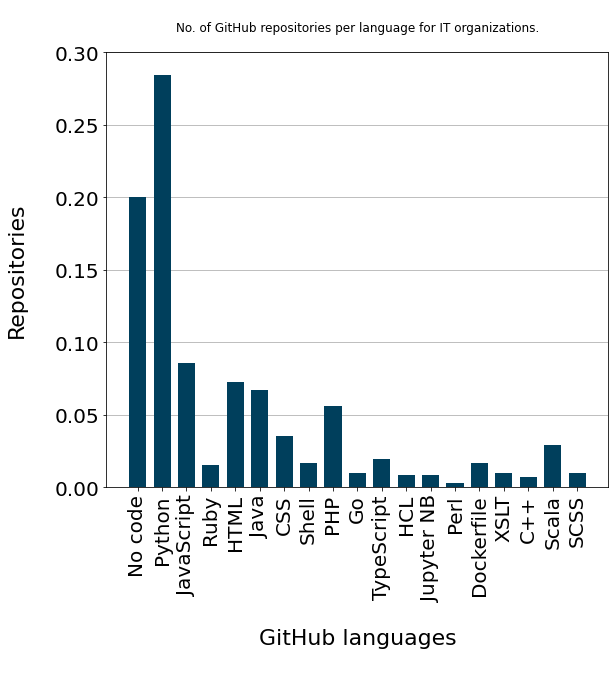

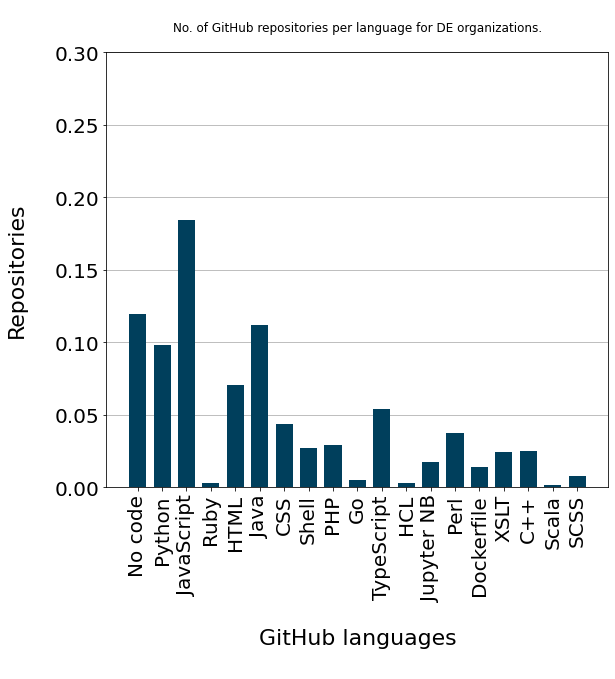

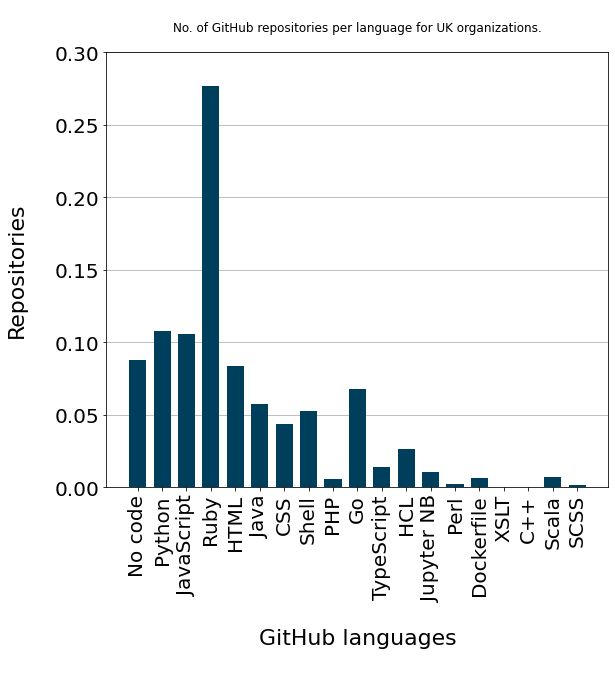

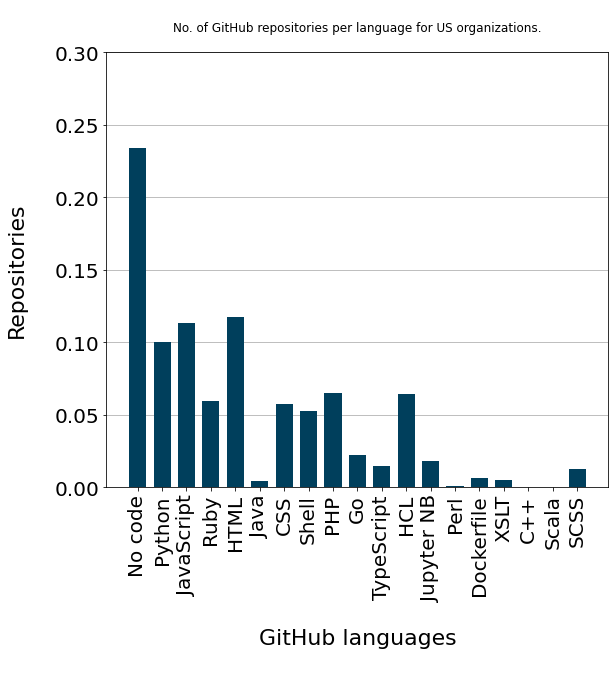

In [7]:
import matplotlib.pyplot as plt
import numpy as np

query = "SELECT r.language, COUNT(*) as language_count FROM repository r LEFT JOIN organization o ON o.url=r.organization WHERE {} GROUP BY r.language ORDER BY language_count DESC"

datasets = list()
datasets = [{ 'id':'IT', 'data':conn.query('SELECT * FROM ({})'.format(query.format('o.country="Italy"')))},
            { 'id':'DE', 'data':conn.query('SELECT * FROM ({})'.format(query.format('o.country="Germany"')))},
            { 'id':'UK', 'data':conn.query('SELECT * FROM ({})'.format(query.format('o.user_name="alphagov"')))},
            { 'id':'US', 'data':conn.query('SELECT * FROM ({})'.format(query.format('o.user_name="GSA"')))} ]
 
languages=[l[0] for l in conn.query('SELECT language FROM ({}) WHERE language_count>30'.format(query.format('o.user_name="GSA" or o.user_name="alphagov" or o.country="Germany" or o.country="Italy"')))]
    
 

for dataset in datasets:
    query_languages= [r[0] for r in dataset['data']]
    query_lan_count=[r[1] for r in dataset['data']]

    y_values=[]
    x_values=languages
    for lan in languages:
        if lan in query_languages:
            y_values.append(int(query_lan_count[query_languages.index(lan)])/sizes[dataset['id']])
 
        else:
            y_values.append(0)


    x_values=[x.replace('Jupyter Notebook','Jupyter NB').replace('None','No code') for x in x_values] 
    fig = plt.figure(figsize = (9, 8))
    plt.grid(zorder=0,axis='y')
    # creating the bar plot
    color =['#003f5c']*len(x_values)
    plt.bar(np.arange(len(x_values)), y_values, color =color,width = 0.7,zorder=3) 
    plt.xticks(np.arange(len(x_values)),x_values,rotation=90)
    plt.ylabel("Repositories\n", fontsize=22)
    plt.xlabel("\nGitHub languages\n", fontsize=22)
    plt.gca().set_ylim([0,0.3])
    plt.title("\nNo. of GitHub repositories per language for {} organizations.\n".format(dataset['id']))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

#### 2) Distribution of sizes (x1)

In [ ]:
from collections import Counter

query = 'SELECT size/1024 FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE {} ORDER BY size DESC'

datasets = [{ 'id':'IT', 'data':list(map(lambda q:q[0], conn.query(query.format('o.country="Italy"'))))},
            { 'id':'DE', 'data':list(map(lambda q:q[0], conn.query(query.format('o.country="Germany"'))))},
            { 'id':'UK', 'data':list(map(lambda q:q[0], conn.query(query.format('o.user_name="alphagov"'))))},
            { 'id':'US', 'data':list(map(lambda q:q[0], conn.query(query.format('o.user_name="GSA"'))))} ]
x_values= list(range(max ([len(d['data']) for d in datasets])))

fig = plt.figure(figsize = (22, 10))
plt.grid(zorder=0,axis='both')

for d in datasets:
    d['data'].extend([0]*(len(x_values)-len(d['data'])))
    plt.plot(x_values,d['data'],label=d['id'])
    
plt.ylabel("MB")
plt.xlabel("Number of repositories")
plt.title(f"\nDistribution of repositories sizes (in MB) for repositories (for the first 40 repositories per size for each dataset)\n")
plt.legend(prop={'size': 15})
plt.xlim([0, 40])
plt.show()

#### 3) Cumulative of the number of repositories over the year (x1)

In [ ]:
from datetime import datetime
x_values=list()
datasets=['Italy','Germany','United Kingdom','United States']
colors=dict(zip(datasets,['#33658A','#F6AE2D','#F26419','#55DDE0']))
for ds in datasets:
    dates=[]
    if ds=='Italy':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.country=\"Italy\"")
    elif ds=='Germany':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.country=\"Germany\"")
    elif ds=='United States':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.user_name=\"GSA\"")
    elif ds=='United Kingdom':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.user_name=\"alphagov\"")
    x_values.extend([date[0] for date in dates])
 
x_values=list(set(x_values))
x_values.sort()
y_values=dict(zip(datasets,[np.zeros(len(x_values)) for x in range(len(datasets))]))

for ds in datasets:
    dates=[]
    if ds=='Italy':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o ON r.organization=o.url WHERE o.country=\"Italy\"")
    elif ds=='Germany':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o ON r.organization=o.url WHERE o.country=\"Germany\"")
    elif ds=='United States':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o ON r.organization=o.url WHERE o.user_name=\"GSA\"")
    elif ds=='United Kingdom':
        dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o ON r.organization=o.url WHERE o.user_name=\"alphagov\"")
    for date in [date[0] for date in dates]:
         y_values[ds][x_values.index(date)]+=1

for label in datasets:
    y_values[label]=np.cumsum(y_values[label])

fig = plt.figure(figsize = (18, 10))
plt.grid(zorder=0,axis='both')
# plot lines
for label in datasets:
    plt.plot(x_values,y_values[label],label=label,color=colors[label])

labels= [datetime.fromtimestamp(timestamp).strftime("%Y") for timestamp in x_values]
labels=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
values=[ 1199145600+x* 31536000 for x in range(len(labels))]
plt.xticks( values ,labels )
plt.ylabel("Repositories", fontsize=14)
plt.xlabel("Years",fontsize=14)
#plt.title(f"\nCumulatives of the number of repositories over the years for the 4 datasets\n")
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

#### 4) Creation and last update dates (x4)

In [ ]:
from datetime import datetime

query_it="SELECT r.timestamp_created_at,r.timestamp_updated_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.country=\"Italy\" ORDER BY r.timestamp_created_at ASC"
query_de="SELECT r.timestamp_created_at,r.timestamp_updated_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.country=\"Germany\" ORDER BY r.timestamp_created_at ASC"
query_us="SELECT r.timestamp_created_at,r.timestamp_updated_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.user_name=\"GSA\" ORDER BY r.timestamp_created_at ASC"
query_uk="SELECT r.timestamp_created_at,r.timestamp_updated_at FROM repository r LEFT JOIN organization o ON r.organization=o.url WHERE o.user_name=\"alphagov\" ORDER BY r.timestamp_created_at ASC" 

datasets=['Italy','Germany','United Kingdom','United States']
colors=dict(zip(datasets,['#33658A','#F6AE2D','#F26419','#55DDE0']))
queries=dict(zip(datasets,[query_it,query_de,query_us,query_uk]))

for label in datasets:
    dates=conn.query(queries[label])
    x_values=list()
    x_values.extend([date[0] for date in dates])
    x_values.extend([date[1] for date in dates])
    x_values=list(set(x_values))
    x_values.sort()
    y_values_created_at=np.zeros(len(x_values))
    y_values_updated_at=np.zeros(len(x_values))
    fig = plt.figure(figsize = (10, 16))
    plt.grid(zorder=0,axis='both')
    offset,step=0,1
    for date in dates:
        if (date[0]>date[1]):
            continue
        plt.plot([date[0],date[1]], [offset,offset],label=label,color=colors[label],linewidth=0.75)
        offset+=step
    labels= [datetime.fromtimestamp(timestamp).strftime("%Y") for timestamp in x_values]
    labels=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
    values=[ 1199145600+x* 31536000 for x in range(len(labels))]
    plt.xticks( values[3:] ,labels[3:] )
    plt.xlabel("Years",fontsize=14)
    plt.xlabel("Repositories",fontsize=14)
    plt.ylim([0, 160])
    plt.title(f"\nCreation date and last update date as segment for each repositories \n of dataset {label}. Repositories are ordered from bottom to top \n by creation date. \n")
    plt.ylim([0, 1600])
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.show()

#### 5) Heat maps of vulnerabilities (x4)

In [ ]:
import sys
import seaborn as sns

def from_vuln_set_to_heat_map(vuln_set,title,ylabel,xlabel):
    
    x_values,y_values = list(range(0,75,5)) + [sys.maxsize],  list(range(0,21,3)) +  [sys.maxsize] # MIN, MAX, STEP  (critical vulns)
    x_values,y_values = [(x_values[i],x_values[i+1]) for i in range(len(x_values)-1)], list(reversed([(y_values[i],y_values[i+1]) for i in range(len(y_values)-1)]))

    list_map = np.zeros((len(y_values),len(x_values)))
    used_vuln=0

    for vuln in vuln_set:
        repo,highs, crits=vuln[0], vuln[1],vuln[2]
        position = get_el_position(x_values,y_values,[highs,crits])
        if highs>0 or crits>0:
            used_vuln+=1
            list_map[position[1],position[0]]+=1 

 
    list_map=list(np.around(np.array(list_map), 4))
    fig, ax = plt.subplots(figsize=(26,15))  
    #plt.title(title)
    
    labels =  (np.around(np.array(list_map)*100/used_vuln,2)).tolist()
    p1 = sns.heatmap(list_map,annot=labels,annot_kws={"size": 23},cbar=False,square=True,fmt='',
                 xticklabels=[str((x[0],x[1]-1)) if x[1]<sys.maxsize-1 else '≥'+str(x[0]) for x in x_values],
                 yticklabels= [str((y[0],y[1]-1)) if y[1]<sys.maxsize-1 else '≥'+str(y[0]) for y in y_values], cmap=cmap ) #cmap=cmap
    
    p1.set_ylabel(ylabel,fontsize=27)
    p1.set_xlabel(xlabel,fontsize=27)
    plt.yticks(rotation=360)
    plt.xticks(rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), size=26)
    ax.set_xticklabels(ax.get_xticklabels(),  size=26) 

In [ ]:
query="""SELECT r.url, IFNULL(SUM(v.severity='High'),0) as High, IFNULL(SUM(v.severity='Critical'),0) as Critical   FROM repository r
                            LEFT JOIN organization o ON o.url=r.organization 
                            LEFT JOIN (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d  ON r.url=d.repository
                            LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a ON d.package=a.package
                            LEFT JOIN vulnerability v ON v.id = a.vulnerability 
                            WHERE {}   GROUP BY r.url """

title="\nHeat map of #critical/#high vulnerabilities per repositories of the \"{}\" dataset. The color of each square is the percentage of repositories with the pair  #high/#critical vulnerabilities in that range. \n"
y_label='Range of #Critical Vulnerabilities'
x_label= '\nRange of #High Vulnerabilities' 
 

vuln_set=conn.query(query.format("o.country=\"Italy\""))
print('Dataset: IT. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('Italy'),y_label,x_label)

vuln_set=conn.query(query.format("o.country=\"Germany\""))
print('Dataset DE. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('Germany'),y_label,x_label )

vuln_set=conn.query(query.format("o.user_name=\"GSA\""))
print('Dataset US. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('US'),y_label,x_label)

vuln_set=conn.query(query.format("o.user_name=\"alphagov\""))
print('Dataset UK. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('UK'),y_label,x_label)

#### 6) Heat maps of unresolved vulnerabilities (x4)

In [ ]:
query="""SELECT r.url, IFNULL(SUM(v.severity='High'),0) as High, IFNULL(SUM(v.severity='Critical'),0) as Critical   FROM repository r
                            LEFT JOIN organization o ON o.url=r.organization 
                            LEFT JOIN (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d  ON r.url=d.repository
                            LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a ON d.package=a.package
                            LEFT JOIN (SELECT * FROM vulnerability WHERE LENGTH(fixed_package_version)<2 ) v ON v.id = a.vulnerability 
                            WHERE {}   GROUP BY r.url """

title="\nHeat map of #critical/#high vulnerabilities that are not resolved as of today per repositories of the \"{}\" dataset. The color of each square is the percentage of repositories with the pair  #high/#critical vulnerabilities in that range. \n"
y_label='Range of #Critical Vulnerabilities'
x_label= '\nRange of #High Vulnerabilities' 
 

vuln_set=conn.query(query.format("o.country=\"Italy\""))
print('Dataset IT. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('Italy'),y_label,x_label)

vuln_set=conn.query(query.format("o.country=\"Germany\""))
print('Dataset DE. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('Germany'),y_label,x_label )

vuln_set=conn.query(query.format("o.user_name=\"GSA\""))
print('Dataset US. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('US'),y_label,x_label)

vuln_set=conn.query(query.format("o.user_name=\"alphagov\""))
print('Dataset UK. Num of repos', len(vuln_set),'Number of repos without vuln:',len([v for v in vuln_set if v[1]==0 and v[2]==0]))
from_vuln_set_to_heat_map(vuln_set,title.format('UK'),y_label,x_label)

#### 7) Distribution of critical + high vulnerabilities (x1)

In [ ]:
def from_vuln_set_to_distros(vuln_set):
    max_value = max ([v[1] for v in vuln_set])
    x_values = list()
    y_values=list(reversed(list(range(max_value))))
    y_values=y_values[:len(y_values)-1]
    for value in y_values:
        x_values.append(len([v[1] for v in vuln_set if v[1]>=value])/len(vuln_set)*100)
    return x_values,y_values
 
def from_set_to_plot(vuln_set_query,title):
    fig = plt.figure(figsize = (26, 12))
    plt.grid(zorder=0,axis='both')
    x,y=from_vuln_set_to_distros(conn.query(vuln_set_query.format('o.country="Italy"')))
    plt.plot(x,y,label="IT")
    x,y=from_vuln_set_to_distros(conn.query(vuln_set_query.format('o.country="Germany"')))
    plt.plot(x,y,label="DE")
    x,y=from_vuln_set_to_distros(conn.query(vuln_set_query.format('o.user_name="GSA"')))
    plt.plot(x,y,label="US")
    x,y=from_vuln_set_to_distros(conn.query(vuln_set_query.format('o.user_name="alphagov"')))
    plt.plot(x,y,label="UK")
    plt.ylabel("Vulnerabilities",fontsize=26)
    plt.xlabel("Repositories (%)",fontsize=26)
    #plt.title(title) #Percentage of repositories that have at least x number of vulnerabilities.
    plt.legend(prop={'size': 26})
    plt.ylim([1, 200])
    plt.yticks([1,40,80,120,160,200])
    plt.xlim([0,40])
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.show()


vuln_set_query="""SELECT r.url, IFNULL(SUM(v.severity='High'),0) + IFNULL(SUM(v.severity='Critical'),0) as tot   FROM repository r
                            LEFT JOIN organization o ON o.url=r.organization 
                            LEFT JOIN (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d  ON r.url=d.repository
                            LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a ON d.package=a.package
                            LEFT JOIN (SELECT * FROM vulnerability ) v ON v.id = a.vulnerability 
                            WHERE {}   GROUP BY r.url ORDER BY tot ASC"""

title= "\n Percentage of repositories that have at least y number of high + critical vulnerabilities.\n"
from_set_to_plot(vuln_set_query,title)

#### 8) Distribution of packages and dependencies types (x4 x2)

In [ ]:
import plotly.express as px 
from matplotlib.pyplot import figure
res=conn.query("""SELECT p.package_manager, COUNT(p.purl) FROM package p GROUP BY p.package_manager""")
def from_query_to_plot(res):
    labels = [r[0] for r in res]
    values = [r[1] for r in res]
    fig = px.pie(values=values, names=labels, 
             color_discrete_sequence=px.colors.sequential.RdBu,width=950,height=500)
 
    fig.update_traces(textposition='inside', 
                 #textinfo='percent+label+value',
                  marker=dict(line=dict(color='#FFFFFF', width=1)),
                  textfont_size=19)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=28)
    ))

    fig.show()
query="""SELECT p.package_manager, COUNT(DISTINCT(p.purl)) FROM (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d 
LEFT JOIN package p ON p.purl=d.package
LEFT JOIN repository r ON d.repository=r.url
LEFT JOIN organization o ON o.url=r.organization
WHERE {}
GROUP BY p.package_manager""" 

print("Distributions of packages")
print('Dataset IT')
from_query_to_plot(conn.query(query.format("o.country=\"Italy\"")))
print('Dataset DE')
from_query_to_plot(conn.query(query.format("o.country=\"Germany\"")))
print('Dataset UK')
from_query_to_plot(conn.query(query.format("o.user_name=\"alphagov\"")))
print('Dataset US')
from_query_to_plot(conn.query(query.format("o.user_name=\"GSA\"")))

query="""SELECT p.package_manager, COUNT(p.purl) FROM (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d 
LEFT JOIN package p ON p.purl=d.package
LEFT JOIN repository r ON d.repository=r.url
LEFT JOIN organization o ON o.url=r.organization
WHERE {}
GROUP BY p.package_manager""" 

print("Distributions of dependencies")
print('Dataset IT')
from_query_to_plot(conn.query(query.format("o.country=\"Italy\"")))
print('Dataset DE')
from_query_to_plot(conn.query(query.format("o.country=\"Germany\"")))
print('Dataset UK')
from_query_to_plot(conn.query(query.format("o.user_name=\"alphagov\"")))
print('Dataset US')
from_query_to_plot(conn.query(query.format("o.user_name=\"GSA\"")))

#### 9) Distribution of vulnerabilities among package managers (x1)

In [ ]:
import plotly.express as px 
res=conn.query(""" SELECT p.package_manager, COUNT(DISTINCT(a.vulnerability)) 
FROM (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 
INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a
LEFT JOIN package p ON a.package=p.purl GROUP BY p.package_manager""")
labels = [r[0] for r in res]
values = [r[1] for r in res]
fig = px.pie(values=values, names=labels, 
             color_discrete_sequence=px.colors.sequential.RdBu,width=1350,height=600 )
 
fig.update_traces(textposition='outside', 
                  textinfo='percent+label',
                  marker=dict(line=dict(color='#FFFFFF', width=2)),
                  textfont_size=22)
fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.00,
        font=dict(size=24)
    ))
fig.show()

#### 10) Distribution of vulnerabilities severity (x1)

In [ ]:
import plotly.express as px 
res=conn.query("""SELECT v.severity, COUNT(*) FROM (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 
INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a 
LEFT JOIN vulnerability v ON a.vulnerability=v.id GROUP BY v.severity""")
labels = [r[0] for r in res]
values = [r[1] for r in res]
fig = px.pie(values=values, names=labels, 
             color_discrete_sequence=px.colors.sequential.RdBu,width=1350,height=600 )
 
fig.update_traces(textposition='outside', 
                  textinfo='percent+label',
                  marker=dict(line=dict(color='#FFFFFF', width=2)),
                  textfont_size=22)
fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1,
        font=dict(size=24)
    ))
fig.show()

#### 11) Heat maps of packages (x4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

np.random.seed(42)
r=list(np.linspace(0.3, 1, 256)) 
for i in range(20):
    r.extend(np.linspace(0.3, 1, 256)) 
r.sort()

colors0 = palettable.colorbrewer.sequential.YlOrBr_8.mpl_colormap(np.linspace(0, 0.3, 256))
colors1 = palettable.colorbrewer.sequential.YlOrBr_8.mpl_colormap(r)
colors3 = palettable.colorbrewer.sequential.Reds_9.mpl_colormap(np.linspace(0.9, 0.9, 256)) 
colors = np.vstack(( colors0,colors1, colors3 ))

cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)


def get_el_position(x_values,y_values, element):
    for x in x_values:
        for y in y_values:
            if element[0]>=x[0] and element[0]<=x[1]:
                if element[1]>=y[0] and element[1]<=y[1]:
                    return x_values.index(x), y_values.index(y)
    return (-1,-1)

def from_vuln_set_to_heat_map(vuln_set,title,ylabel,xlabel):
    
    x_values,y_values = list(range(0,14,1)) + [sys.maxsize],  list(range(0,7,1)) +  [sys.maxsize] # MIN, MAX, STEP  (critical vulns)
    x_values,y_values = [(x_values[i],x_values[i+1]) for i in range(len(x_values)-1)], list(reversed([(y_values[i],y_values[i+1]) for i in range(len(y_values)-1)]))
    x_values,y_values=[(x[0],x[1]-1) for x in x_values],[(y[0],y[1]-1) for y in y_values]

    list_map = np.zeros((len(y_values),len(x_values)))
    used_vuln=0

    for vuln in vuln_set:
        repo,highs, crits=vuln[0], vuln[1],vuln[2]
        position = get_el_position(x_values,y_values,[highs,crits])
        if highs>0 or crits>0:
            used_vuln+=1
            list_map[position[1],position[0]]+=1 

 
    list_map=list(np.around(np.array(list_map), 4))
    fig, ax = plt.subplots(figsize=(26,15))  
    #plt.title(title)
    
    labels =  (np.around(np.array(list_map)*100/used_vuln,2)).tolist()
    labels[len(labels)-1][0]=''
    p1 = sns.heatmap(list_map,annot=labels,annot_kws={"size": 23},cbar=False,square=True,fmt='',
                 xticklabels=[x[0] if x[0]==x[1] else str(x) if x[1]<sys.maxsize-1 else '>'+str(x[0]) for x in x_values],
                 yticklabels= [y[0] if y[0]==y[1] else str(y) if y[1]<sys.maxsize-1 else '>'+str(y[0]) for y in y_values], cmap=cmap ) #cmap=cmap

    p1.set_ylabel(ylabel,fontsize=27)
    p1.set_xlabel(xlabel,fontsize=27)
    plt.yticks(rotation=360)
    #plt.xticks(rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), size=26)
    ax.set_xticklabels(ax.get_xticklabels(),  size=26) 

In [ ]:
query="""SELECT p.purl, IFNULL(SUM(v.severity='High'),0) as High, IFNULL(SUM(v.severity='Critical'),0) as Critical FROM package p 
LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a 
ON a.package=p.purl LEFT JOIN vulnerability v ON v.id=a.vulnerability WHERE fixed_package_version="" GROUP BY p.purl"""

vuln_set=conn.query(query.format("1=1"))
print("Total packages",len(vuln_set),'Packages with at least one high or critical vuln',len([v for v in vuln_set if v[1]>0 or v[2]>0]))

title='\nHeat map of #critical/#high vulnerabilities for each packages found with at least one high or critical vulnerability. The color of each square is related to the percentage of packages with the pair #critical/#high vulnerabilities in that range.\n'
from_vuln_set_to_heat_map(vuln_set,title,"\nRange of #critical vulnerabilities\n","\nRange of #high vulnerabilities\n")

#### 12) Fraction of repositories with an assigned language (x1)

In [ ]:
query_dep="""SELECT COUNT (*) FROM repository r LEFT JOIN organization o ON o.url=r.organization WHERE  r.language!='None'
and {}""" 
query_all="""SELECT COUNT(*) FROM repository r LEFT JOIN organization o ON o.url=r.organization WHERE {}"""

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot

data=[
    conn.query(query_dep.format('o.country="Italy"'))[0][0]/conn.query(query_all.format('o.country="Italy"'))[0][0],
    conn.query(query_dep.format('o.country="Germany"'))[0][0]/conn.query(query_all.format('o.country="Germany"'))[0][0],
    conn.query(query_dep.format('o.user_name="GSA"'))[0][0]/conn.query(query_all.format('o.user_name="GSA"'))[0][0],
    conn.query(query_dep.format('o.user_name="alphagov"'))[0][0]/conn.query(query_all.format('o.user_name="alphagov"'))[0][0]

]
plt.bar(['Italy','Germany','US','UK'], data, color ='#003f5c',width = 0.6,zorder=3) 
plt.ylabel("Fraction of repositories ")
plt.xlabel("Datasets")
plt.ylim(0, 1)
plt.title(f"\n Fraction of repositories that have a language (assigned by GitHub) . \n")
plt.show()

#### 13) Fraction of repositories with at least one dep (x1)

In [ ]:
query_dep="""SELECT COUNT (*) FROM repository r LEFT JOIN organization o ON o.url=r.organization WHERE r.url  IN 
(SELECT distinct(url) FROM repository INNER JOIN (SELECT repository FROM parsed_dependency UNION SELECT repository FROM manifest_dependency) ON url=repository)
and {}""" 
query_all="""SELECT COUNT(*) FROM repository r LEFT JOIN organization o ON o.url=r.organization WHERE {}"""

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot

data=[
    conn.query(query_dep.format('o.country="Italy"'))[0][0]/conn.query(query_all.format('o.country="Italy"'))[0][0],
    conn.query(query_dep.format('o.country="Germany"'))[0][0]/conn.query(query_all.format('o.country="Germany"'))[0][0],
    conn.query(query_dep.format('o.user_name="GSA"'))[0][0]/conn.query(query_all.format('o.user_name="GSA"'))[0][0],
    conn.query(query_dep.format('o.user_name="alphagov"'))[0][0]/conn.query(query_all.format('o.user_name="alphagov"'))[0][0]

]
plt.bar(['Italy','Germany','US','UK'], data, color ='#003f5c',width = 0.6,zorder=3) 
plt.ylabel("Fraction of repositories ")
plt.xlabel("Datasets")
plt.title(f"\n Fraction of repositories for which at least one dependency has been found. \n")
plt.show()

#### 14) Fraction of repositories with at least one high or critical vuln (x1)

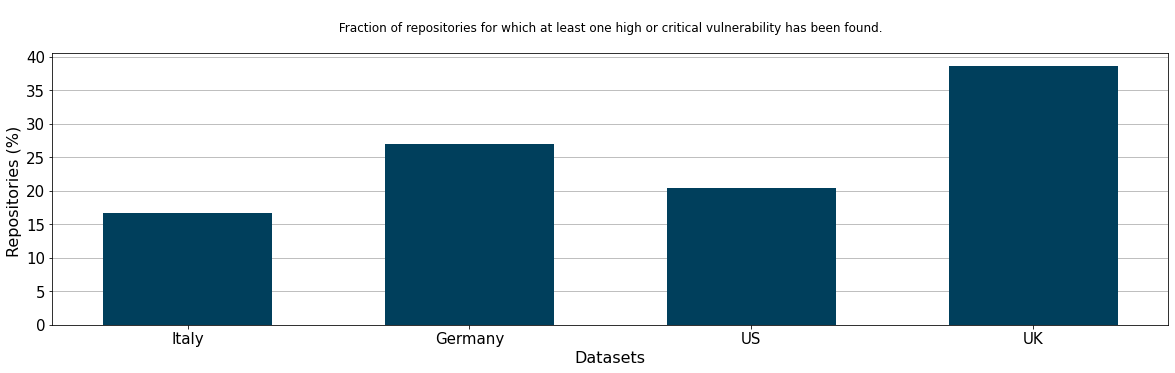

In [8]:
fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
 
query=""" SELECT r.url, COUNT(DISTINCT(a.vulnerability)) FROM repository r 
          INNER JOIN organization o ON o.url=r.organization
          INNER JOIN (SELECT repository,package FROM parsed_dependency UNION SELECT repository,package FROM manifest_dependency) d ON d.repository=r.url
          LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a ON a.package=d.package
          LEFT JOIN vulnerability v ON v.id = a.vulnerability
          WHERE {} AND (v.severity="High" or v.severity="Critical")
          GROUP BY r.url
          
"""
data = [len([el for el in conn.query(query.format('o.country="Italy"')) if el[1]>0])/sizes["IT"]*100,
        len([el for el in conn.query(query.format('o.country="Germany"')) if el[1]>0])/sizes["DE"]*100,
        len([el for el in conn.query(query.format('o.user_name="GSA"')) if el[1]>0])/sizes["US"]*100,
        len([el for el in conn.query(query.format('o.user_name="alphagov"')) if el[1]>0])/sizes["UK"]*100]
 


plt.bar(['Italy','Germany','US','UK'], data, color ='#003f5c',width = 0.6,zorder=3) 
plt.ylabel("Repositories (%) ",fontsize=16)
plt.xlabel("Datasets",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title(f"\n Fraction of repositories for which at least one high or critical vulnerability has been found. \n")
plt.show()

#### 15) Fraction of repositories with at least one unresolved high or critical vuln (x1)

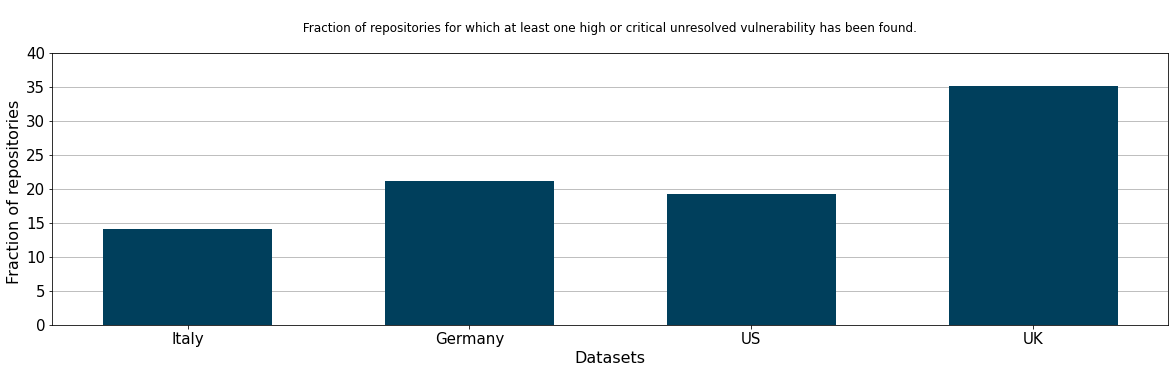

In [10]:
fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
 
query=""" SELECT r.url, COUNT(DISTINCT(a.vulnerability)) FROM repository r 
          INNER JOIN organization o ON o.url=r.organization
          INNER JOIN (SELECT repository,package FROM parsed_dependency UNION SELECT repository,package FROM manifest_dependency) d ON d.repository=r.url
          LEFT JOIN (SELECT a1.vulnerability,a1.package FROM grype_potential_affection a1 INNER JOIN osv_api_potential_affection a2 ON a1.vulnerability=a2.vulnerability and a1.package=a2.package) a ON a.package=d.package
          LEFT JOIN vulnerability v ON v.id = a.vulnerability
          WHERE {} AND (v.severity="High" or v.severity="Critical") and v.fixed_package_version=""
          GROUP BY r.url
          
"""
data = [len([el for el in conn.query(query.format('o.country="Italy"')) if el[1]>0])/sizes["IT"]*100,
        len([el for el in conn.query(query.format('o.country="Germany"')) if el[1]>0])/sizes["DE"]*100,
        len([el for el in conn.query(query.format('o.user_name="GSA"')) if el[1]>0])/sizes["US"]*100,
        len([el for el in conn.query(query.format('o.user_name="alphagov"')) if el[1]>0])/sizes["UK"]*100]

plt.bar(['Italy','Germany','US','UK'], data, color ='#003f5c',width = 0.6,zorder=3) 
plt.ylabel("Fraction of repositories ",fontsize=16)
plt.xlabel("Datasets",fontsize=16)
plt.title(f"\n Fraction of repositories for which at least one high or critical unresolved vulnerability has been found. \n")
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gca().set_ylim([0,40])
plt.show()

#### 16) Top 30 packages by percentage of repos that depend on them (x4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
  
def from_result_to_barplot( dataset_name,query_where,num_of_repos):
  
        result=  conn.query(f"""  SELECT * FROM( 
                SELECT p.purl,p.name,p.package_manager, IFNULL(COUNT(r.url),0)  as repos, p.version  FROM package p 
                        LEFT JOIN (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d ON p.purl=d.package
                        LEFT JOIN repository r ON r.url= d.repository 
                        LEFT JOIN organization o ON r.organization=o.url
                        WHERE {query_where} GROUP BY p.purl )  ORDER BY repos DESC,  name DESC""")
        fig = plt.figure(figsize = (25, 8))
        plt.grid(zorder=0,axis='y')
        color_map={
                'npm':'c',
                'pypi':'maroon',
                'gem': 'y',
                'maven':'green',
                'golang':'black',
                'cargo':'red',
                'cocoapods':'m',
                'nuget':'b'        }

        plt.bar([r[1] for r in result][:30], [r[3]*100/num_of_repos for r in result][:30], color= [color_map[r[2]] for r in result][:30]  ,zorder=3, #color ='maroon'
        width = 0.6)
        plt.xticks(np.arange(len([r[1] for r in result][:30])),[r[1]+' '+r[4]  for r in result][:30],rotation=90,fontsize=22 ) 
        plt.ylabel("Repositories (%)",fontsize=22)
        plt.xlabel("\nPackages",fontsize=22)
        plt.title(f"\nTop 30 packages by percentage (%) of repositories that depend on them for the dataset \"{dataset_name}\"\n", fontsize = 26)
        legend_elements=[matplotlib.lines.Line2D ([0], [0], color=color_map[pck_man], lw=4, label=pck_man ) for pck_man in color_map.keys() ]
        plt.legend(handles=legend_elements, prop={'size': 22},ncol=4);
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.ylim([0,20])
        plt.show()

In [ ]:
from_result_to_barplot(  "Italy","o.country=\"Italy\"",713)
from_result_to_barplot( "Germany","o.country=\"Germany\"",1304)
from_result_to_barplot( "US","o.user_name=\"GSA\"",937)
from_result_to_barplot( "UK","o.user_name=\"alphagov\"",1557)

#### 17) Venn diagrams of vulnerabilities (x1)

In [ ]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted,venn3_circles,venn3

grype_cpe_vulns=[e[0] for e in conn.query("""SELECT DISTINCT t1.id FROM vulnerability t1 
INNER JOIN grype_cpe_potential_affection t2   ON t1.id=t2.vulnerability""")]

grype_vulns=[e[0] for e in conn.query("""SELECT DISTINCT t1.id  FROM vulnerability t1 
INNER JOIN grype_potential_affection t2  ON t1.id=t2.vulnerability """)]

osv_api_vulns=[e[0] for e in conn.query("""SELECT DISTINCT t1.id  FROM vulnerability t1 
INNER JOIN osv_api_potential_affection t2  ON t1.id=t2.vulnerability """)]

plt.figure(figsize=(17,11))
v=venn3_unweighted(subsets = [set(grype_vulns),set(grype_cpe_vulns),set(osv_api_vulns)],set_labels = ('grype', 'grype_cpe','osv_api'))
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
for text in v.set_labels:
    text.set_fontsize(25)
for text in v.subset_labels:
    text.set_fontsize(24)
plt.gca().set_facecolor('w')
plt.show()

#### 18) Venn diagrams of affections (x1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted,venn3_circles,venn3

grype_cpe_aff=[e[0] for e in conn.query("""SELECT vulnerability || package FROM grype_cpe_potential_affection""")]
grype_aff=[e[0] for e in conn.query("""SELECT vulnerability || package FROM grype_potential_affection""")]
osv_api_aff=[e[0] for e in conn.query("""SELECT vulnerability || package FROM osv_api_potential_affection""")]

plt.figure(figsize=(17,11))
v=venn3_unweighted(subsets = [set(grype_aff),set(grype_cpe_aff),set(osv_api_aff)],set_labels = ('grype', 'grype_cpe','osv_api\n'))

c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
for text in v.set_labels:
    text.set_fontsize(25)
for text in v.subset_labels:
    text.set_fontsize(24)
plt.gca().set_facecolor('w')
plt.show()

#### 19) Cumulative of the number of repos with at least a certain number of deps (x1)

In [ ]:
def from_set_to_dist(vuln_set):
    max_value = max ([v[1] for v in vuln_set])
    x_values = list()
    y_values=list(reversed(list(range(max_value))))

    y_values=y_values[:len(y_values)-1]
    for value in y_values:
        x_values.append(len([v[1] for v in vuln_set if v[1]>=value])/len(vuln_set)*100)
    return x_values,y_values

q="""SELECT r.url,COUNT(*) as dep FROM repository r 
            LEFT JOIN (SELECT * FROM manifest_dependency UNION SELECT * FROM parsed_dependency) d ON d.repository=r.url
            LEFT JOIN package p ON p.purl=d.package
            LEFT JOIN organization o ON o.url=r.organization 
            WHERE  p.package_manager=\"{}\" and r.language=\"{}\"
            GROUP BY r.url 
            ORDER BY dep DESC""" 

legend_el=['npm','pypi','gem','maven','golang']
legend_map=dict(zip(legend_el,["JavaScript","Python","Ruby","Java","Go"]))
fig = plt.figure(figsize = (18, 16))
plt.grid(zorder=0,axis='both')

for pm in legend_el:
    x,y=from_set_to_dist(conn.query(q.format(pm,legend_map[pm])))
    x.insert(0,0)
    y.insert(0,y[0])
    plt.plot(x,y,label=legend_map[pm],linewidth=2.5)

plt.ylabel("Dependencies",fontsize=26)
plt.xlabel("Repositories (%)",fontsize=26)
 
plt.legend(prop={'size': 28})
plt.ylim([0, 2800])
#plt.yticks([1,40,80,120,160,200])
plt.xlim([0,100])
plt.tick_params(axis='both', which='major', labelsize=24)
plt.show()

#### 20) Fraction of empty repos for the top X countries (x1)

In [ ]:
import matplotlib

X=16
result= conn.query(f"SELECT country, COUNT(DISTINCT(o.user_name)) as orgs_count, COUNT(*) as number_of_repos FROM organization o LEFT JOIN repository r ON r.organization=o.url WHERE o.country!=\"nan\" and o.country!=\"European Union\" and o.country!=\"United Nations\" GROUP BY country ORDER BY orgs_count DESC LIMIT {X}")               
x_values=list()
y_values=list()
result=[r[0] for r in result]
for country in result:
    r=conn.query(f"SELECT o.country, SUM(r.size=0), COUNT(*) FROM organization o LEFT JOIN repository r ON o.url=r.organization WHERE o.country=\"{country}\" GROUP BY o.country ")[0]
    x_values.append(r[0] )
    y_values.append(r[1]/r[2])

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), y_values, color= '#003f5c' ,width = 0.7,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=45)
plt.ylabel("\nRepositories", fontsize=16 )
plt.xlabel("Countries", fontsize=16 )
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title(f"\nFraction of empty repositories (for the top {X} countries per number of organizations)\n")
 
plt.show()

#### 21) Num. of orgs and average members and followers per country (x3)

In [ ]:
X=16
result= conn.query(f"SELECT country, COUNT(*) as orgs_count, AVG(members) as members, AVG(followers) as followers FROM organization WHERE country!='nan' and country!='European Union' and country!='United Nations' GROUP BY country ORDER BY orgs_count DESC LIMIT {X}")

x_values=[r[0] for r in result] 
x_values=list(map(lambda x: x if x != 'nan' and x!='United Nations' and x!='European Union' else 'No Country', x_values))
orgs_values=[r[1] for r in result] 
members_values=[r[2] for r in result] 
followers_values=[r[3] for r in result] 
# creating the dataset 

fig = plt.figure(figsize = (16, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), orgs_values, color ='#003f5c',width = 0.6,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=45)
plt.ylabel("GitHub organizations", fontsize=14 )
plt.xlabel("Countries", fontsize=14 )
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('')
 
plt.title(f"\nNo. of GitHub organizations per country (for the top {X} countries per number of organizations)\n")
plt.show()
width=0.35
fig = plt.figure(figsize = (16, 5))
plt.grid(zorder=0,axis='y')
plt.bar(np.arange(len(x_values))+width, members_values, color ='#58508d',width = 0.3,zorder=3,label='avg members per org') 
plt.bar(np.arange(len(x_values))+2*width, followers_values, color ='#ff6361',width = 0.3,zorder=3,label='avg followers per org') 
plt.xticks(np.arange(len(x_values))+width*3/2,x_values,rotation=45)
plt.ylabel("GitHub users\n", fontsize=14)
plt.xlabel(" Countries", fontsize=14)
plt.title(f"\nAvg no. of members and followers per organizations per country (for the top {X} countries per number of organizations)\n")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend(prop={'size': 14})

plt.show()

#### 22) Cumulative of the number of orgs over the time (x1)

In [ ]:
from datetime import datetime

X=16
x_values=list()
country_names=list()
for res in conn.query(f"SELECT country, COUNT(*) as orgs_count FROM organization WHERE country!=\"nan\" and country!=\"European Union\" and country!=\"United Nations\" GROUP BY country ORDER BY orgs_count DESC LIMIT {X}"):
    name=res[0] if res[0]!='nan' else 'No Country'
    country_names.append(name)
    dates=conn.query('SELECT timestamp_created_at FROM organization  WHERE country=\"{}\" and country!=\"nan\" and country!=\"European Union\" and country!=\"United Nations\" ORDER BY timestamp_created_at ASC'.format(res[0]))
    x_values.extend([date[0] for date in dates])
 
x_values=list(set(x_values))
x_values.sort()
y_values=dict(zip(country_names,[np.zeros(len(x_values)) for x in range(X)]))

for res in conn.query(f"SELECT country, COUNT(*) as orgs_count FROM organization WHERE country!=\"nan\" and country!=\"European Union\" and country!=\"United Nations\" GROUP BY country ORDER BY orgs_count DESC LIMIT {X}"):
    name=res[0] if res[0]!='nan' else 'No Country'
    dates=conn.query('SELECT timestamp_created_at FROM organization  WHERE country=\"{}\" and country!=\"nan\" and country!=\"European Union\" and country!=\"United Nations\" ORDER BY timestamp_created_at ASC'.format(res[0]))
    for timestamp in [date[0] for date in dates]:
        y_values[name][x_values.index(timestamp)]+=1

for country_name in country_names:
    y_values[country_name]=np.cumsum(y_values[country_name])
    for i in range(len(y_values[country_name])):
        y_values[country_name][i]=y_values[country_name][i]/y_values[country_name][len(y_values[country_name])-1]

fig = plt.figure(figsize = (18, 15))
plt.grid(zorder=0,axis='both')
# plot lines
for country in country_names:
    plt.plot(x_values,y_values[country],label=country)


labels= [datetime.fromtimestamp(timestamp).strftime("%Y") for timestamp in x_values]

labels=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
values=[ 1199145600+x* 31536000 for x in range(len(labels))]
plt.xticks( values ,labels )
plt.ylabel("\nNo. of GitHub organizations", fontsize=18 )
plt.xlabel("\nYears", fontsize=18 )
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title(f"\n Relative no. of GitHub organizations per country over the years (for the top {X} countries per number of organizations)\n")
plt.legend( prop={'size': 20})
plt.show()

#### 23) Absolute and relative number of verified organizations (x2)

In [ ]:
X=18
result= conn.query(f"SELECT country, COUNT(*) as orgs_count, SUM(is_verified) as verified, SUM(is_verified)*100/COUNT(*) as verified_rel FROM organization GROUP BY country ORDER BY orgs_count DESC LIMIT {X}")

x_values=[r[0] for r in result] 
x_values=list(map(lambda x: x if x != 'nan' else 'No Country', x_values))
orgs_values=[r[1] for r in result] 
verified_absolute=[r[2] for r in result] 
verified_relative=[r[3] for r in result] 
# creating the dataset 

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), verified_absolute, color ='#003f5c',width = 0.7,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=45)
plt.ylabel("GitHub organizations", fontsize=14)
plt.title(f"\nTotal number of verified repositories per country (for the top {X} countries per number of organizations)\n")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), verified_relative, color ='#003f5c',width = 0.7,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=45)
plt.ylabel("GitHub organizations (%)", fontsize=14)
plt.title(f"\nPercentage of verified repositories with respect to total number of repositories per country (for the top {X} countries per number of organizations)\n")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

#### 24) Most used language per country (x1)

In [ ]:
import matplotlib

X=16
result= conn.query(f"SELECT country, COUNT(DISTINCT(o.user_name)) as orgs_count, COUNT(*) as number_of_repos FROM organization o LEFT JOIN repository r ON r.organization=o.url WHERE o.country!=\"nan\" and o.country!=\"European Union\" and o.country!=\"United Nations\" GROUP BY country ORDER BY orgs_count DESC LIMIT {X}")
color_map={
                'JavaScript':'#E5BEED',
                'No Code':'#9593D9',
                'Python': '#7C90DB',
                'PHP':'#736B92',
                'Kotlin':'#7D5C65',   
                   }
                
x_values=list()
y_values=list()
langs=list()
result=[r[0] for r in result]
for country in result:
    r=conn.query(f"""SELECT  country,  language, MAX(repos), SUM(repos) FROM(
    SELECT o.country,r.language,count(*) as repos FROM organization o 
    LEFT JOIN repository r ON o.url=r.organization
    GROUP BY o.country,r.language)
    WHERE country=\"{country}\"
    GROUP BY  country""")[0]
    x_values.append(r[0] )
    y_values.append(r[2]/r[3])
    langs.append(r[1] if r[1]!='None' else 'No Code')

fig = plt.figure(figsize = (20, 5))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), y_values, color= [color_map[r] for r in langs] ,width = 0.7,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=65)
plt.ylabel("Repositories", fontsize=18)
plt.xlabel("Countries", fontsize=18)
#plt.title(f"\nFraction of repositories labeled with the most popular language (for the top {X} countries per number of organizations)\n")
legend_elements=[matplotlib.lines.Line2D ([0], [0], color=color_map[pck_man], lw=6, label=pck_man ) for pck_man in color_map.keys() ]
plt.legend(handles=legend_elements, prop={'size': 17},ncol=4);
plt.tick_params(axis='both', which='major', labelsize=17)
plt.show()

#### 25) Average and tot number of repos per country (x2)

In [ ]:
X=16
result= conn.query(f"SELECT country, COUNT(DISTINCT(o.user_name)) as orgs_count, COUNT(*) as number_of_repos FROM organization o LEFT JOIN repository r ON r.organization=o.url WHERE o.country!=\"nan\" and o.country!=\"European Union\" and o.country!=\"United Nations\" GROUP BY country ORDER BY orgs_count DESC LIMIT {X}")
x_values=[r[0] for r in result] 
x_values=list(map(lambda x: x if x != 'nan' else 'No Country', x_values))
orgs_values=[r[1] for r in result] 
verified_absolute=[r[2] for r in result] 
result=conn.query(f"SELECT country, COUNT(*) as num_of_orgs, AVG(num_of_repo) FROM (SELECT o.country,o.url,COUNT(r.url) as num_of_repo FROM organization o LEFT JOIN repository r ON r.organization=o.url GROUP BY o.url) WHERE  country!=\"nan\" and  country!=\"European Union\" and  country!=\"United Nations\" GROUP BY country ORDER BY num_of_orgs DESC LIMIT {X}")
verified_relative=[r[2] for r in result] 
# creating the dataset 

fig = plt.figure(figsize = (20, 7))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plots =plt.bar(np.arange(len(x_values)), verified_absolute, color ='#003f5c',width = 0.7,zorder=3) 
for bar in plots.patches:
    if bar.get_height()!=713:
        continue;
    plt.annotate('Le repository di organizzazioni \n italiane sono 713',#format(bar.get_height(), '.2f')
                   xy=(bar.get_x() + bar.get_width() / 2 ,bar.get_height()),  horizontalalignment='center', verticalalignment='top',
                   size=24, 
                   xytext=(-215,240),#xytext=(-1.2,11300),
                   textcoords='offset points',
                   bbox=dict(boxstyle="round", alpha=0.1),
                   arrowprops=dict(facecolor='black', shrink=0.05,width=0.5 ),)

plt.xticks(np.arange(len(x_values)),x_values,rotation=75)
plt.ylabel("\nGitHub repositories", fontsize=24)
plt.xlabel("Countries", fontsize=24)
plt.title(f"\nTotal number of repositories per country (for the top {X} countries per number of organizations)\n")
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

fig = plt.figure(figsize = (25,8))
plt.grid(zorder=0,axis='y')
# creating the bar plot
plt.bar(np.arange(len(x_values)), verified_relative, color ='#003f5c',width = 0.7,zorder=3) 
plt.xticks(np.arange(len(x_values)),x_values,rotation=45)
plt.ylabel("\nGitHub repositories", fontsize=20)
plt.xlabel("Countries", fontsize=16)

plt.title(f"\nAverage number of repositories per organization per country (for the top {X} countries per number of organizations)\n")
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

#### 26) Cumulative of the number of repos over the year (x1)

In [ ]:
from datetime import datetime

X=16
x_values=list()
orgs=conn.query(f"SELECT o.country, o.url, COUNT(r.url) as num_of_repo FROM organization o LEFT JOIN repository r ON r.organization=o.url WHERE o.country!=\"nan\" and o.country!=\"European Union\" and o.country!=\"United Nations\" GROUP BY o.url ORDER BY num_of_repo DESC LIMIT {X}")
orgs_label=[org[1].split('/')[len(org[1].split('/'))-1]+' ('+(org[0] if org[0]!='nan' else 'No Country')+')' for org in orgs]
orgs_url=[org[1] for org in orgs]

for org in orgs_url:
    dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o WHERE o.url=\"{org}\"")
    x_values.extend([date[0] for date in dates])
 
x_values=list(set(x_values))
x_values.sort()
x_values
y_values=dict(zip(orgs_label,[np.zeros(len(x_values)) for x in range(X)]))

for org in orgs:
    url=org[1]
    name=org[1].split('/')[len(org[1].split('/'))-1]+' ('+(org[0] if org[0]!='nan' else 'No Country')+')'
    dates= conn.query(f"SELECT r.timestamp_created_at FROM repository r INNER JOIN organization o ON r.organization=o.url WHERE o.country!=\"nan\" and o.country!=\"European Union\" and o.country!=\"United Nations\" and o.url=\"{url}\"")
    for date in [date[0] for date in dates]:
         y_values[name][x_values.index(date)]+=1

for label in orgs_label:
    y_values[label]=np.cumsum(y_values[label])

fig = plt.figure(figsize = (13, 15))
plt.grid(zorder=0,axis='both')
# plot lines
for label in orgs_label:
    plt.plot(x_values,y_values[label],label=label)

labels= [datetime.fromtimestamp(timestamp).strftime("%Y") for timestamp in x_values]

labels=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
values=[ 1199145600+x* 31536000 for x in range(len(labels))]
plt.xticks( values ,labels )
plt.ylabel("\nNo. of GitHub repositories", fontsize=15)
plt.xlabel("Years", fontsize=15)
plt.title(f"\nCumulative of the number of repositories over the years (for the top {X} organizations per number of repositories)\n")
plt.legend( prop={'size': 15})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()